# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/classification_data/classification_data.zip'
!cp "{zip_path}" .
!unzip -q classification_data.zip
!rm classification_data.zip


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [ ]:
data_dir = '/content/classification_data/'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([
#                                       transforms.RandomRotation(30),
#                                       transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.Resize(255),
#                                       transforms.CenterCrop(224),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
#                                      transforms.Resize(255),
#                                      transforms.CenterCrop(224),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

print(train_data.classes)
num_classes = len(train_data.classes)

['11st', 'AUCTION', 'CUPANG', 'GMARKET', 'GSSHOP', 'HMAL', 'MUSINSA']


We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [ ]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [ ]:
import time

In [ ]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Device = cpu; Time per batch: 3.928 seconds
Device = cuda; Time per batch: 0.006 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, num_classes),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

cuda


In [ ]:
epochs = 10
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/10.. Train loss: 2.206.. Test loss: 1.880.. Test accuracy: 0.274
Epoch 2/10.. Train loss: 1.578.. Test loss: 1.650.. Test accuracy: 0.311
Epoch 2/10.. Train loss: 1.275.. Test loss: 1.195.. Test accuracy: 0.624
Epoch 3/10.. Train loss: 1.046.. Test loss: 0.904.. Test accuracy: 0.705
Epoch 3/10.. Train loss: 0.757.. Test loss: 0.689.. Test accuracy: 0.755
Epoch 4/10.. Train loss: 0.586.. Test loss: 0.458.. Test accuracy: 0.923
Epoch 4/10.. Train loss: 0.498.. Test loss: 0.396.. Test accuracy: 0.919
Epoch 5/10.. Train loss: 0.428.. Test loss: 0.284.. Test accuracy: 0.965
Epoch 5/10.. Train loss: 0.313.. Test loss: 0.225.. Test accuracy: 0.955
Epoch 6/10.. Train loss: 0.240.. Test loss: 0.153.. Test accuracy: 0.979
Epoch 7/10.. Train loss: 0.202.. Test loss: 0.129.. Test accuracy: 0.988
Epoch 7/10.. Train loss: 0.198.. Test loss: 0.112.. Test accuracy: 0.986
Epoch 8/10.. Train loss: 0.194.. Test loss: 0.083.. Test accuracy: 0.993
Epoch 8/10.. Train loss: 0.141.. Test loss: 0.071..

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
#    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.imshow((img.numpy().squeeze()))
    ax1.axis('off')
    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(len(ps)))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [ ]:
test_iter = iter(testloader)


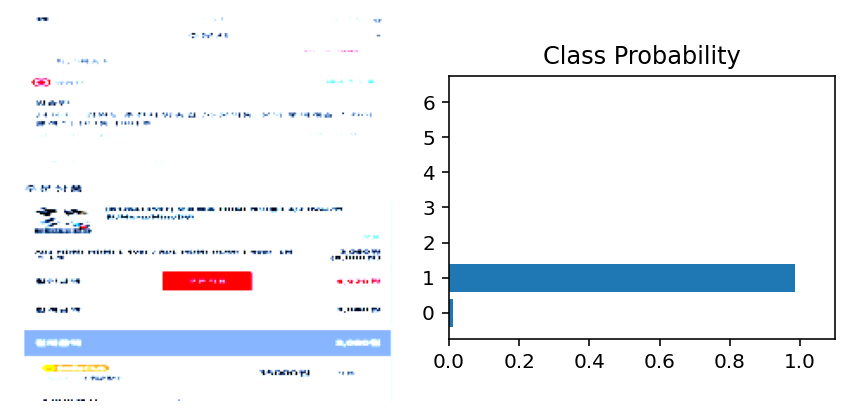

In [ ]:
test_inputs, test_labels = next(test_iter)

model.eval()
with torch.no_grad():
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    test_logps = model.forward(test_inputs)
    test_ps = torch.exp(test_logps)

    for i in range(1):  #range(len(test_inputs)):
#        plt.figure()
#        plt.imshow(test_inputs[i].cpu().numpy().transpose(1,2,0))
        img = torch.from_numpy(test_inputs[i].cpu().numpy().transpose(1,2,0))
        img = np.clip(img, 0.0, 1.0)
        view_classify(img, test_ps[i].cpu())
#model.train()


In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from glob import glob


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
top = '/content/template_matching_data'
for root, dirs, files in os.walk(top, topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))

In [4]:
zip_path = '/content/drive/MyDrive/template_matching_data.zip'
!cp "{zip_path}" .
!unzip -q template_matching_data.zip
!rm template_matching_data.zip

In [5]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

class TemplateMatchingDataset(Dataset):
  def __init__(self, root_dir, img_transform=None, tmp_transform=None):
    self.root_dir = root_dir
    self.img_transform = img_transform
    self.tmp_transform = tmp_transform
    self.samples = self.make_dataset(self.root_dir)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    img_path, tmp_path, cls_id = self.samples[idx]
    img = self.pil_loader(img_path)
    tmp = self.pil_loader(tmp_path)
    if self.img_transform is not None:
      img = self.img_transform(img)
    if self.tmp_transform is not None:
      tmp = self.tmp_transform(tmp)
    return img, tmp, cls_id

  @staticmethod
  def make_dataset(directory: str):
    instances = []
    class_dirs = [(0, 'negative'), (1, 'positive')]

    for cls_dir in class_dirs:
      cls_pos = cls_dir[0]
      dir_pos = directory + '/' + cls_dir[1]

      if os.path.isdir(dir_pos):   
        files = os.listdir(dir_pos)
        num_samples = int(len(files) / 2)
        for i in range(num_samples):
          img_path = os.path.join(dir_pos, str(i) + '_image.jpg')
          tmp_path = os.path.join(dir_pos, str(i) + '_templ.jpg')
          item = img_path, tmp_path, cls_pos
          instances.append(item)
      else:
        raise FileNotFoundError(f"Couldn't find subfolder {dir_pos}.")

    return instances

  @staticmethod
  def pil_loader(path: str):
    with open(path, 'rb') as f:
      img = Image.open(f)
      return img.convert('RGB')
  

In [8]:
data_dir = '/content/template_matching_data/'

# TODO: Define transforms for the training data and testing data
img_transforms = transforms.Compose([
#                                       transforms.RandomRotation(30),
#                                       transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.Resize(255),
#                                       transforms.CenterCrop(224),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

tmp_transforms = transforms.Compose([
#                                      transforms.Resize(255),
#                                      transforms.CenterCrop(224),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = TemplateMatchingDataset(data_dir + '/train', img_transform=img_transforms, tmp_transform=tmp_transforms)
test_data = TemplateMatchingDataset(data_dir + '/test', img_transform=img_transforms, tmp_transform=tmp_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [9]:
import torch
from torch import nn
from torchvision import models

class TemplateIdentifier(nn.Module):
    def __init__(self):
      super(TemplateIdentifier, self).__init__()
      self.feature_extractor1 = models.densenet121(pretrained=True)
      self.feature_extractor2 = models.densenet121(pretrained=True)

      for param in self.feature_extractor1.parameters():
        param.requires_grad = False

      for param in self.feature_extractor2.parameters():
        param.requries_grad = False

      self.feature_extractor1.classifier = nn.Linear(1024, 1024)
      self.feature_extractor2.classifier = nn.Linear(1024, 1024)

      self.feature_identifier = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 16),
                                            nn.ReLU(),
                                            nn.Dropout(0.2),
                                            nn.Linear(16, 2),
                                            nn.LogSoftmax(dim=1))

    def forward(self, input1, input2):
      feature1 = self.feature_extractor1.forward(input1)
      feature2 = self.feature_extractor2.forward(input2)
      combined_feature = torch.cat((feature1, feature2), dim=1)
      output = self.feature_identifier.forward(combined_feature)
      return output



In [10]:
model = TemplateIdentifier()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TemplateIdentifier(
  (feature_extractor1): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, e

In [11]:
print(len(train_data))
print(len(train_loader))

print(len(test_data))
print(len(test_loader))


10000
313
1000
32


In [12]:
train_iter = iter(train_loader)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


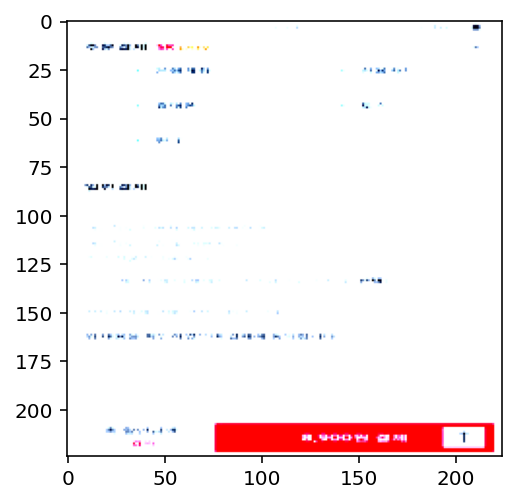

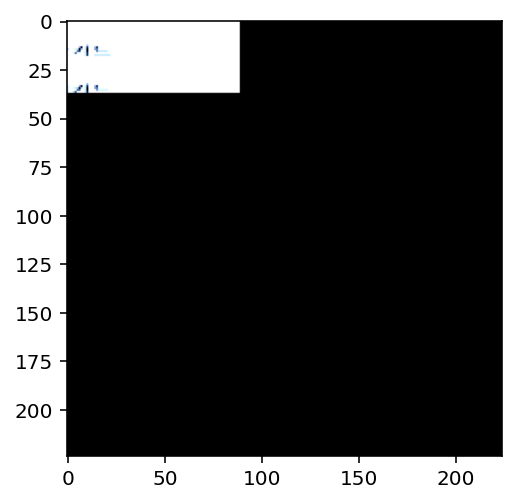

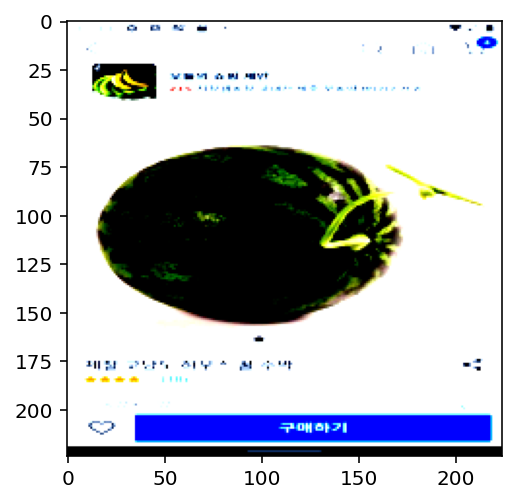

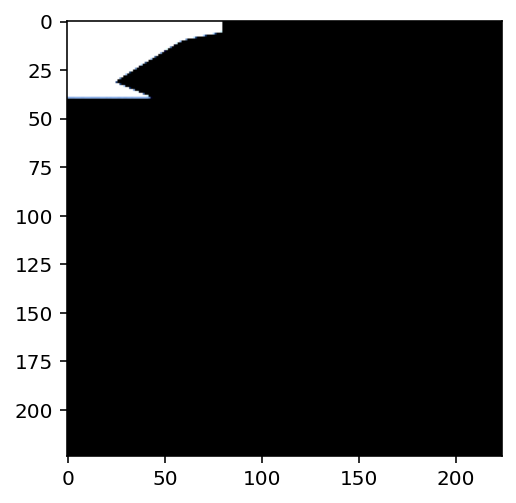

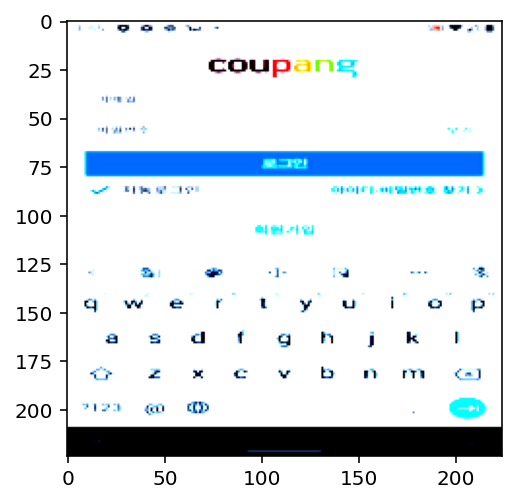

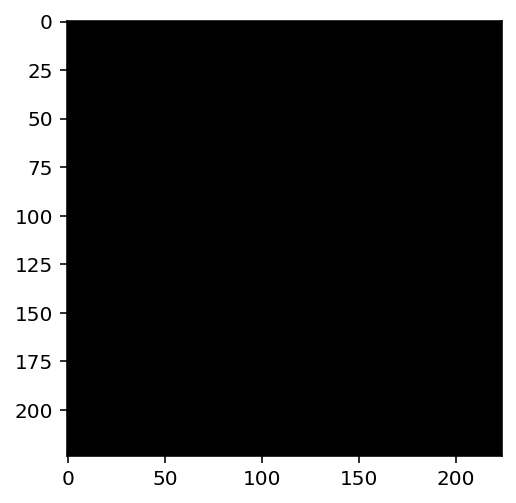

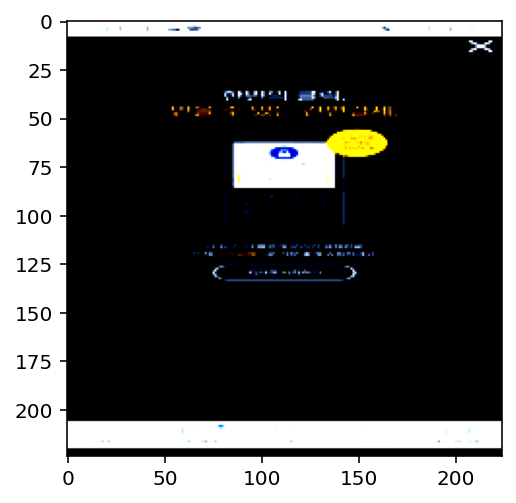

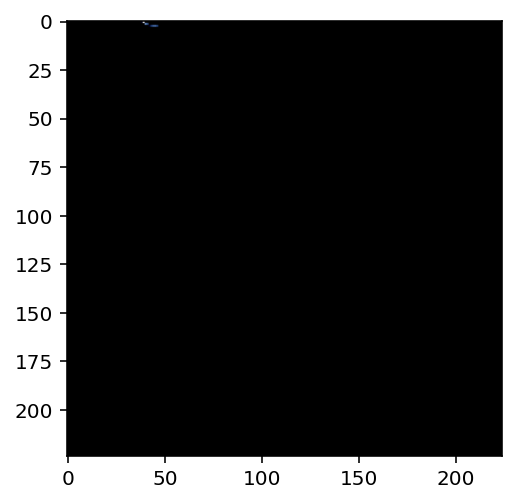

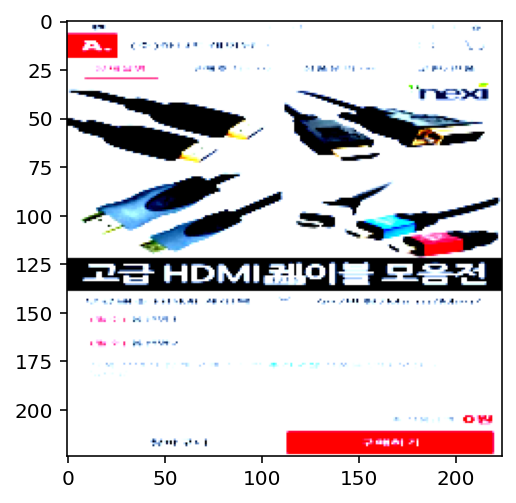

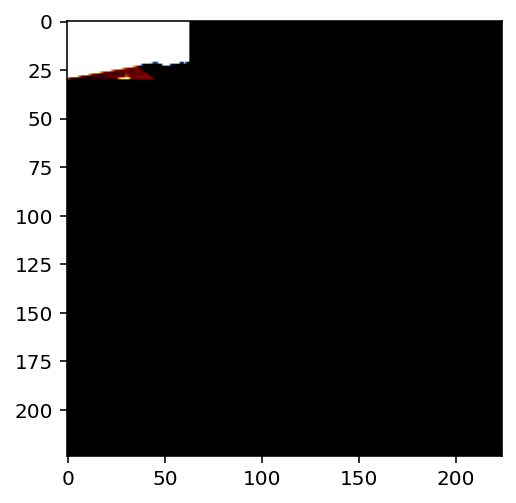

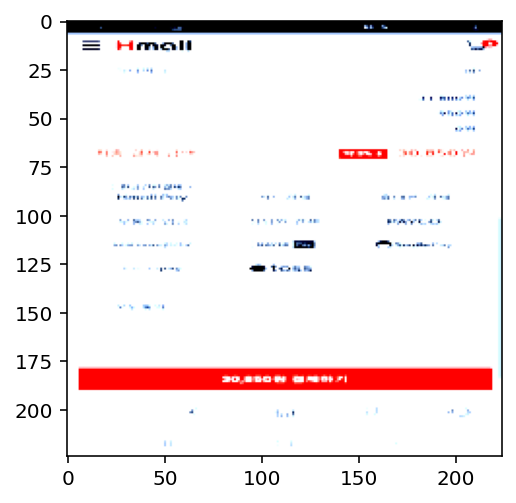

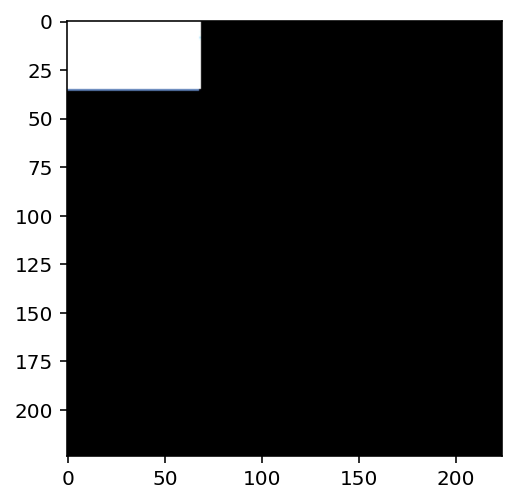

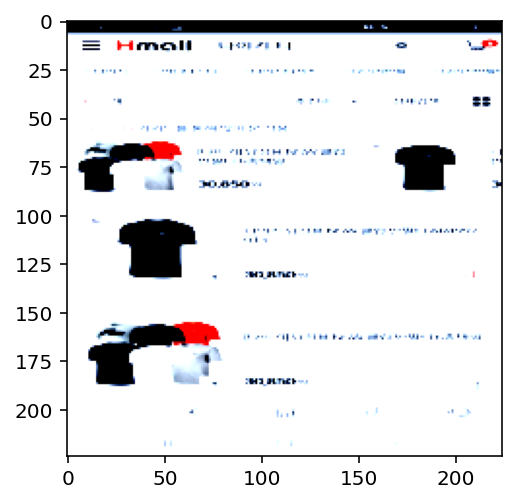

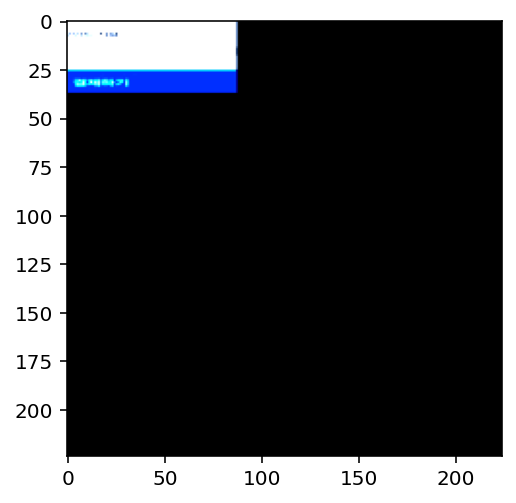

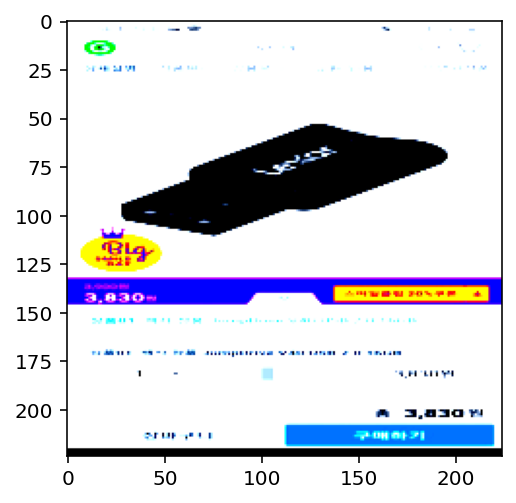

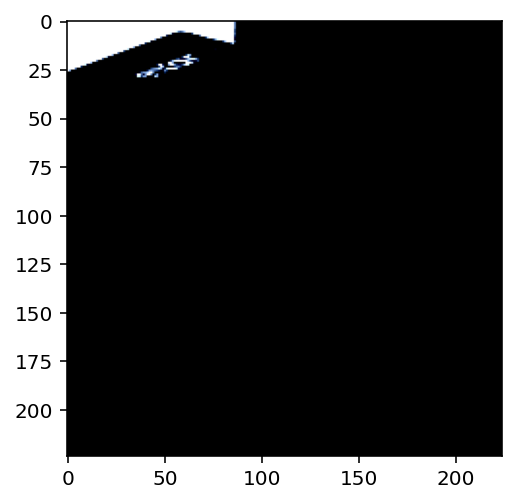

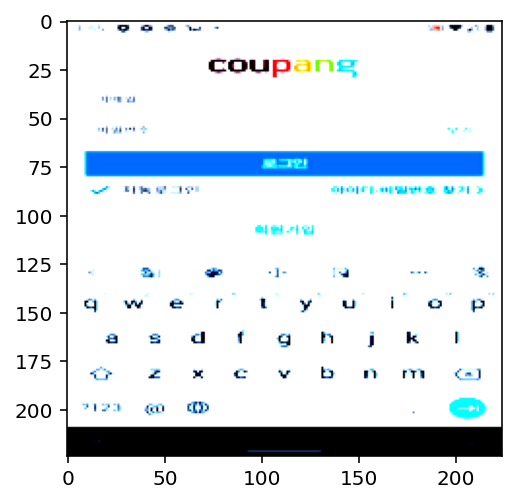

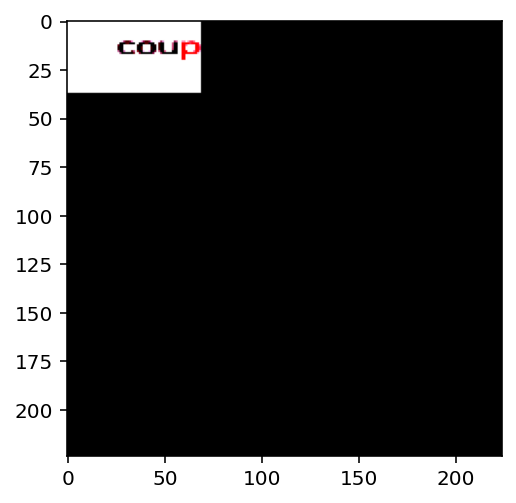

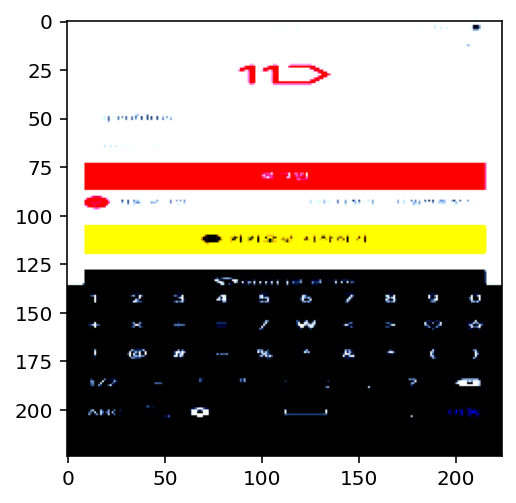

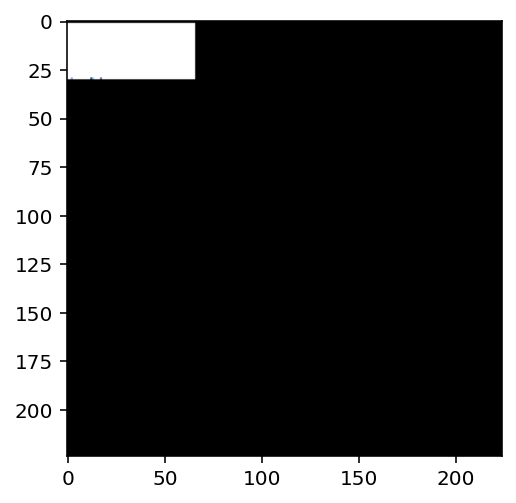

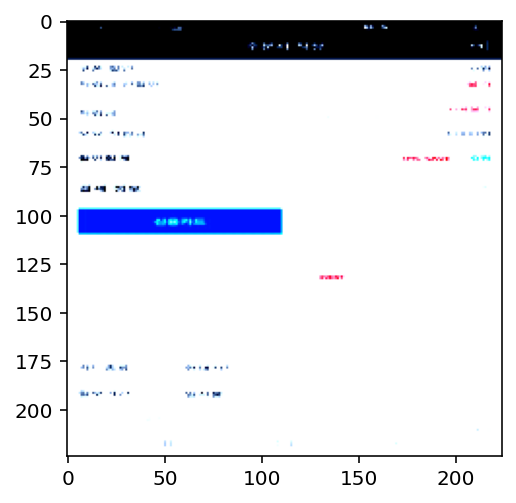

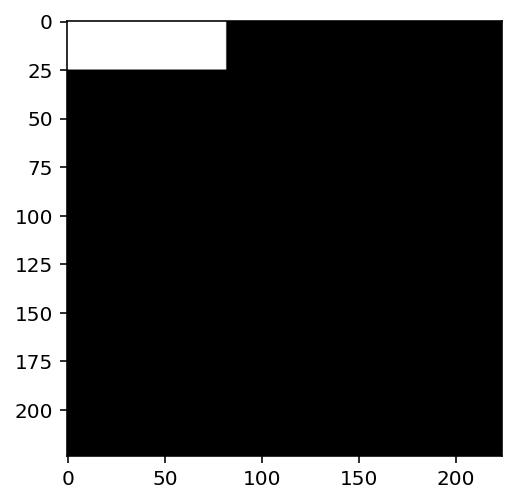

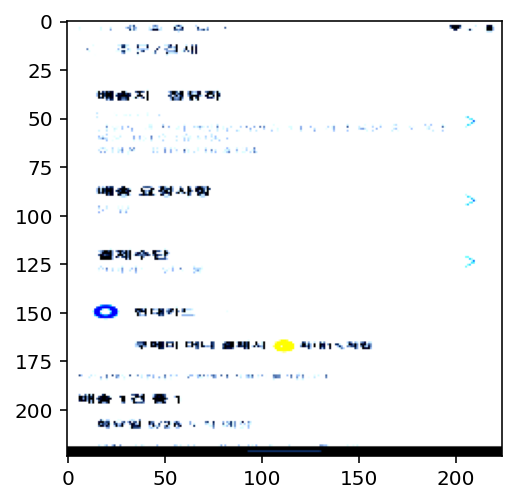

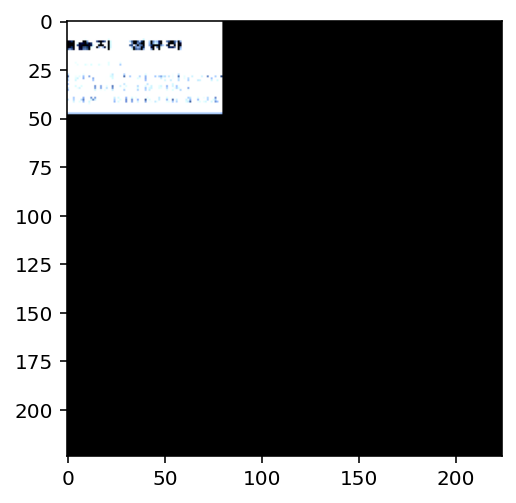

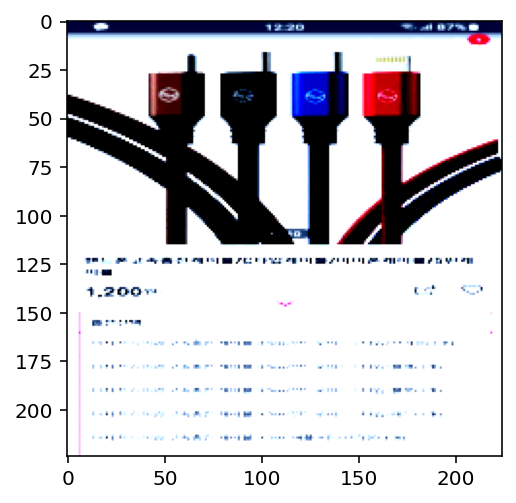

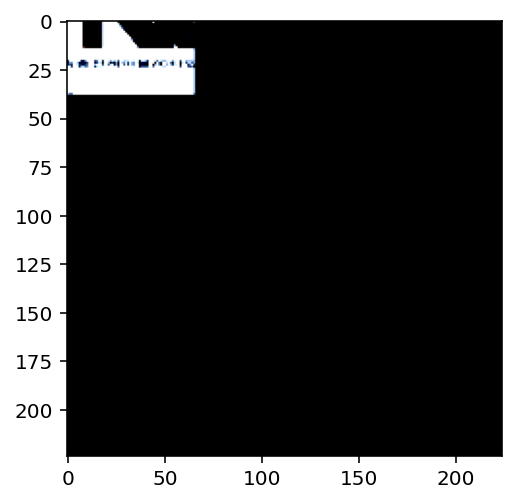

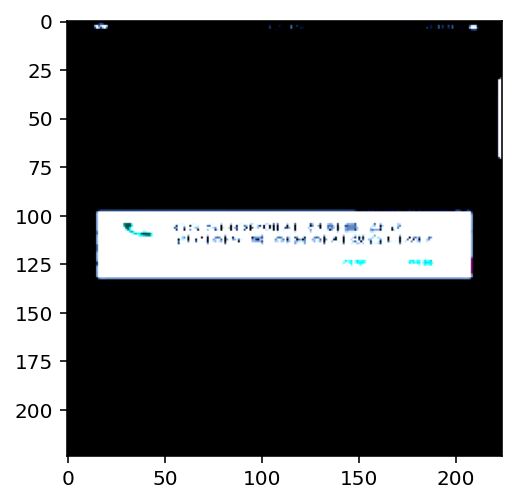

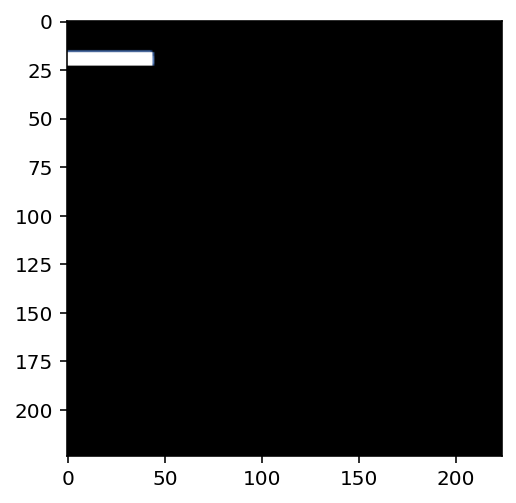

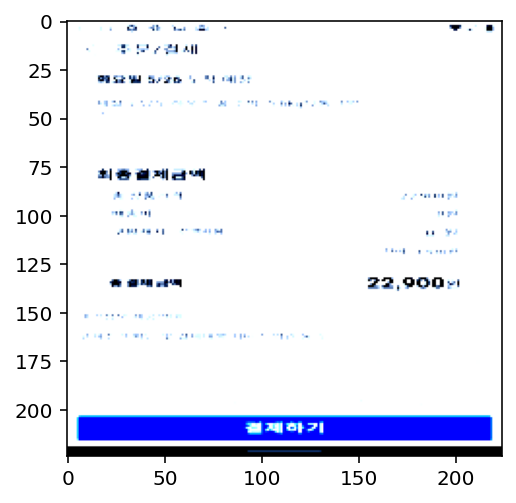

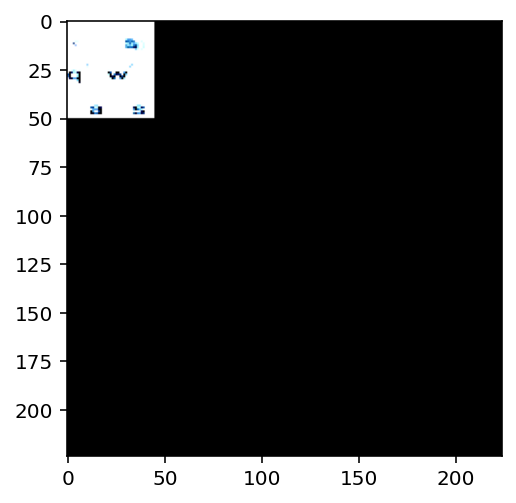

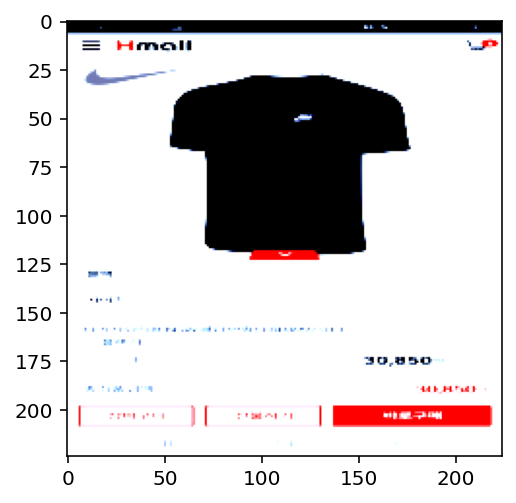

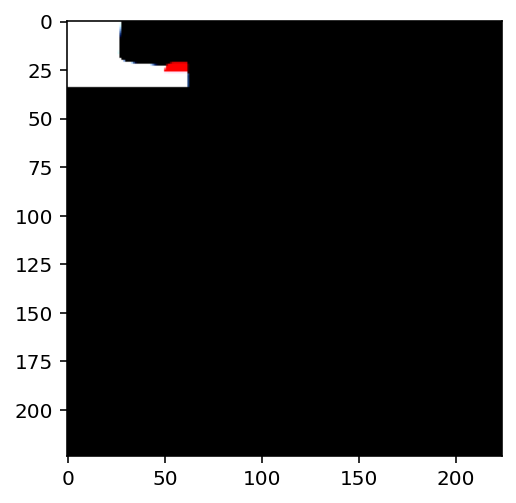

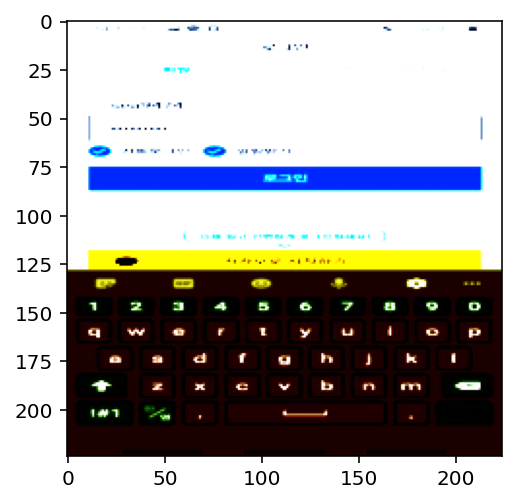

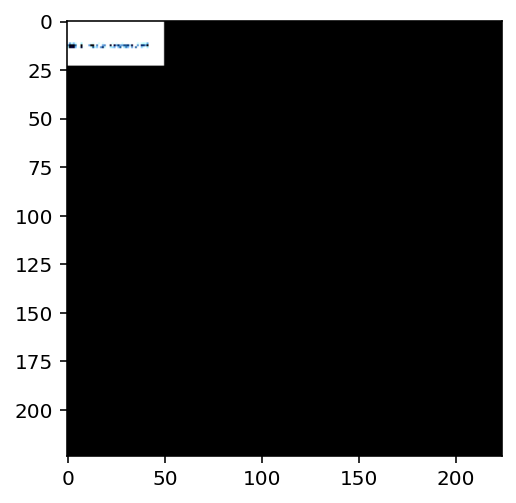

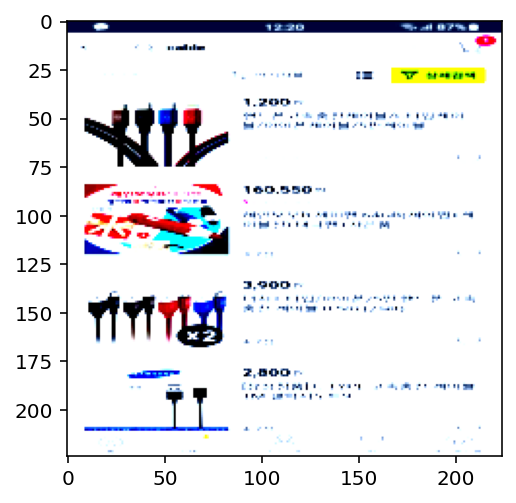

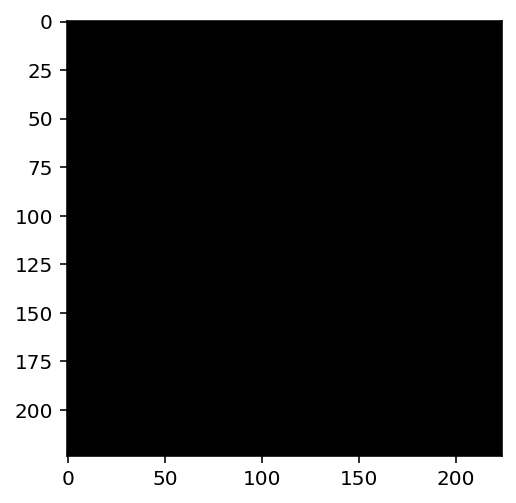

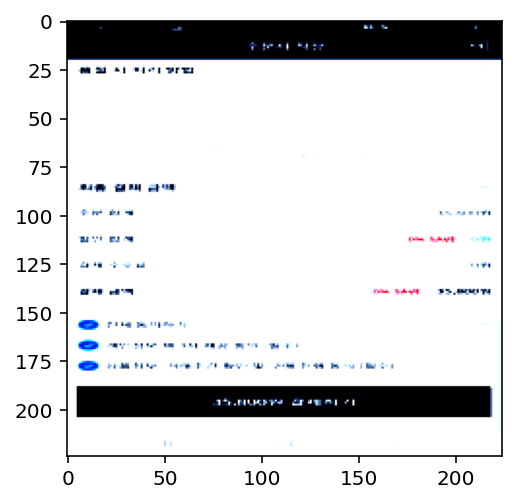

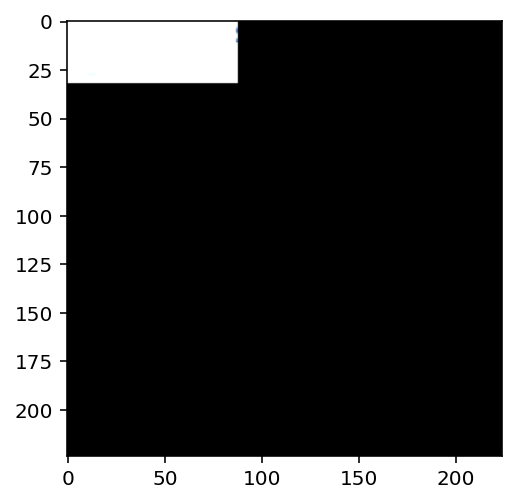

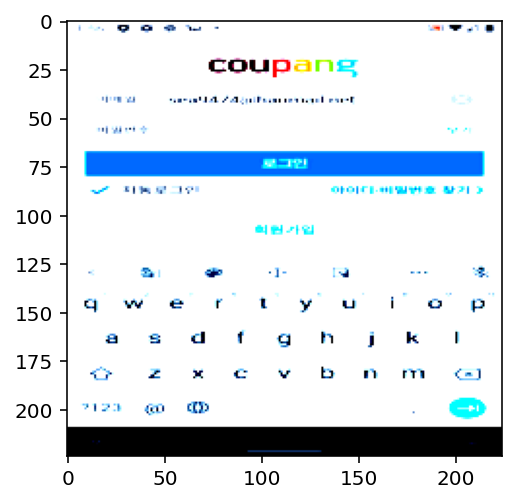

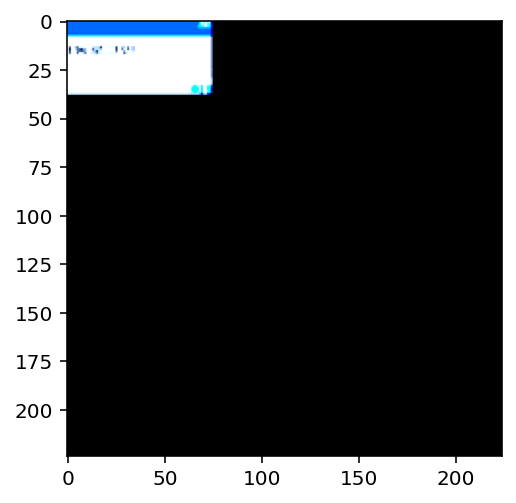

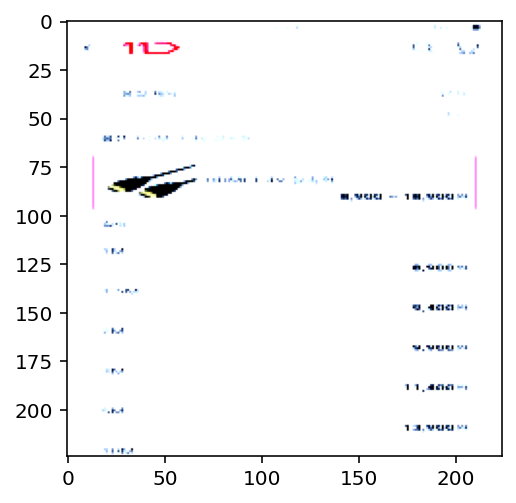

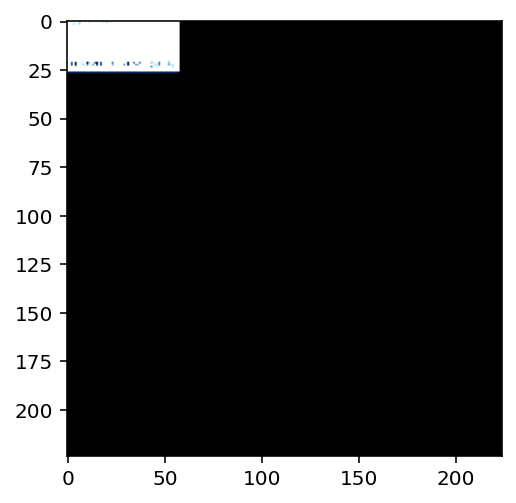

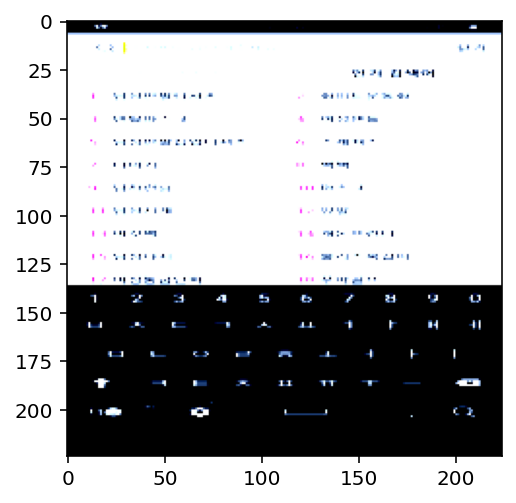

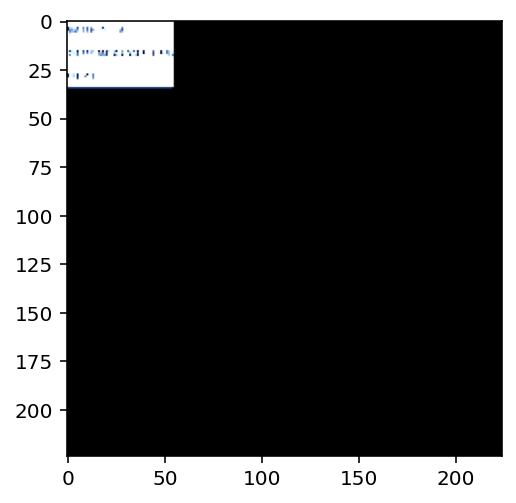

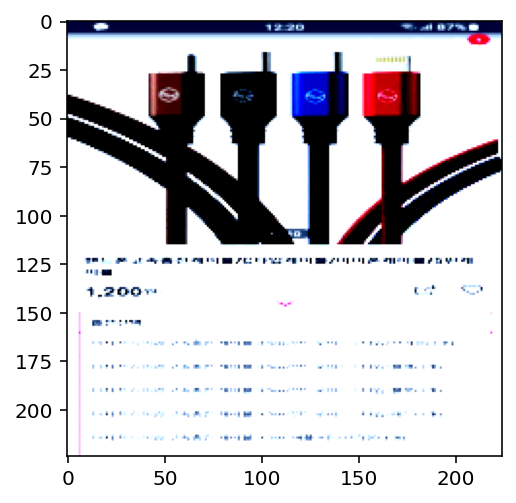

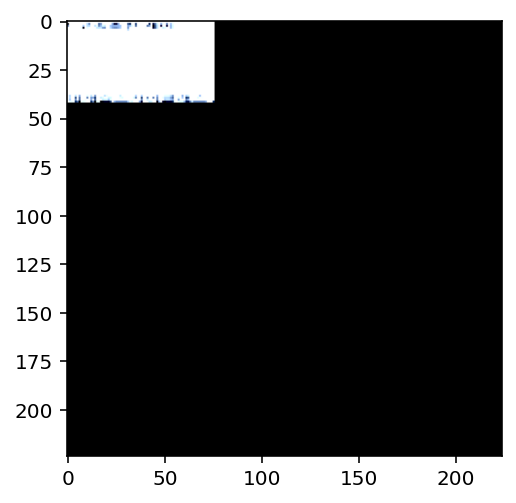

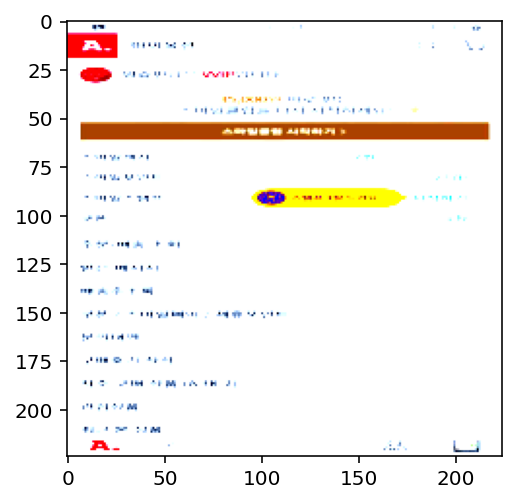

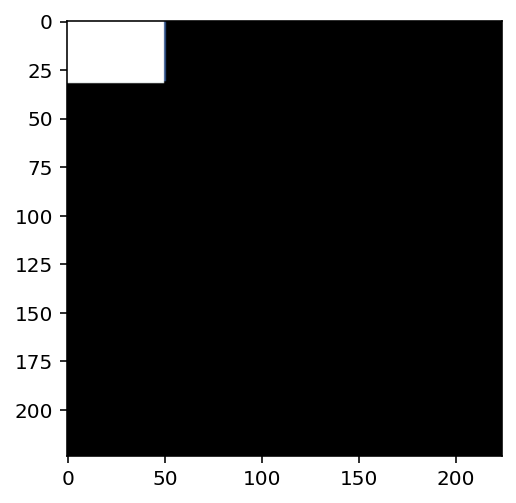

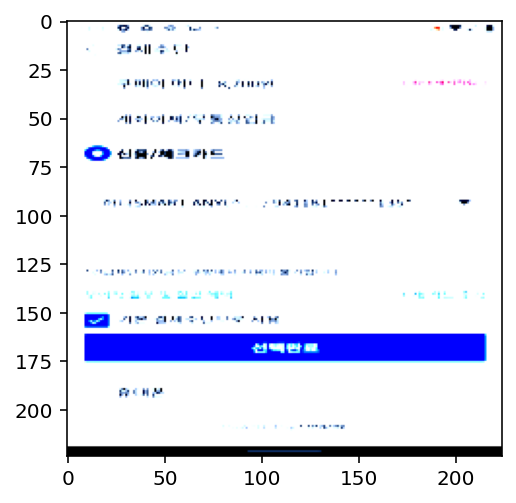

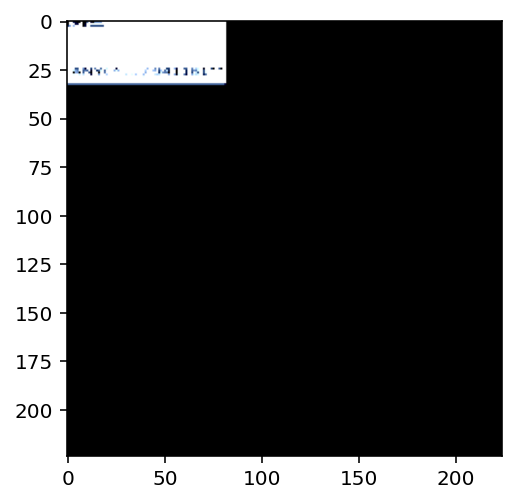

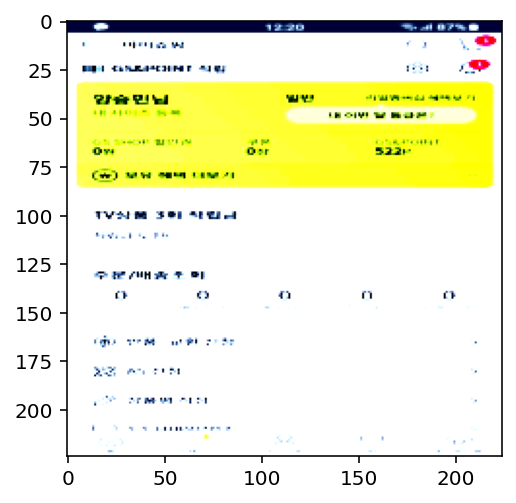

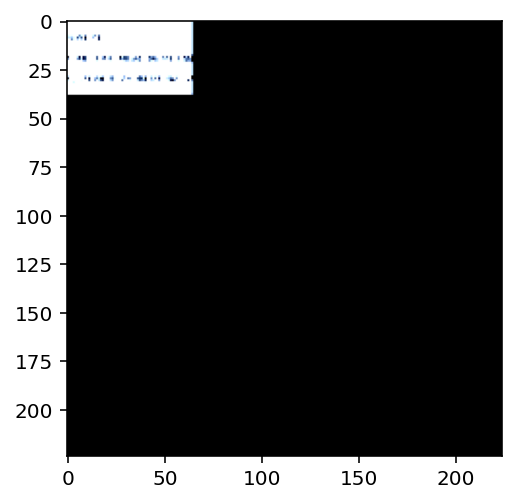

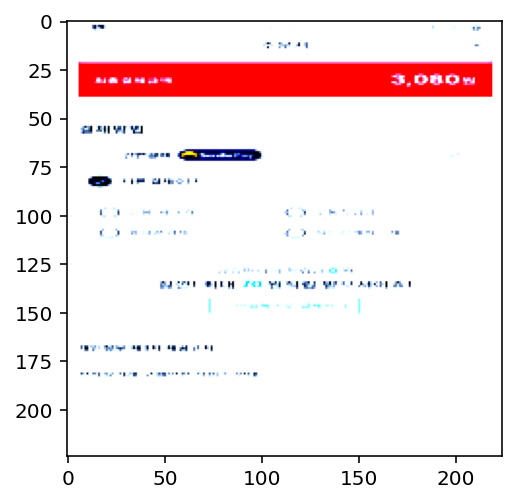

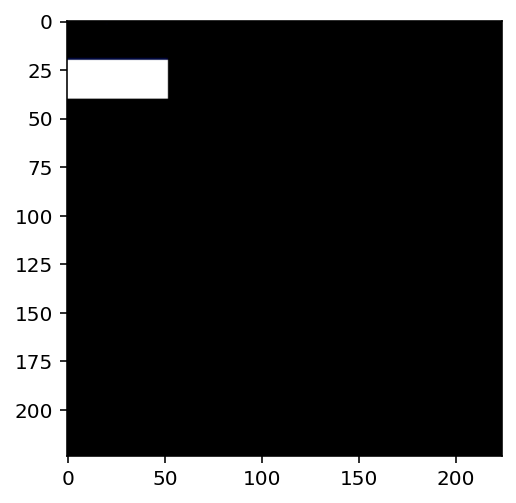

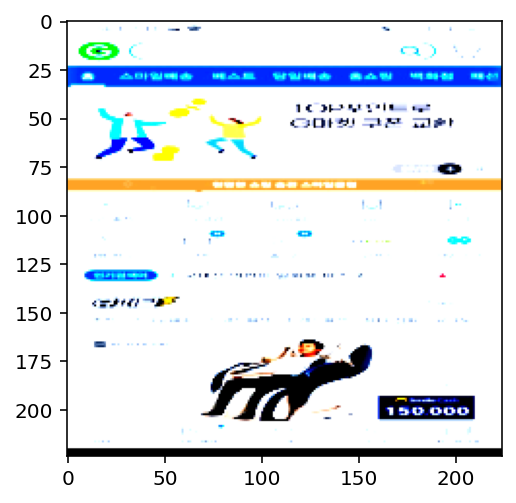

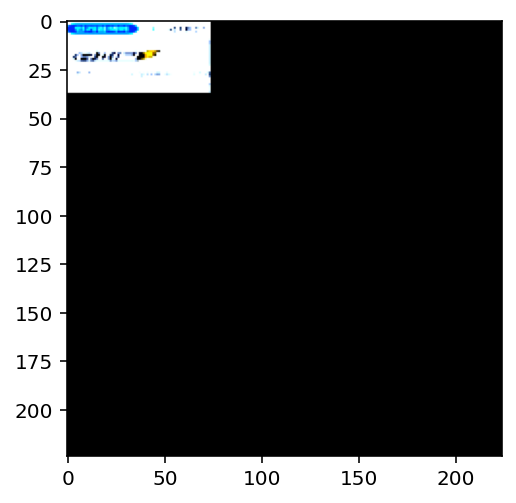

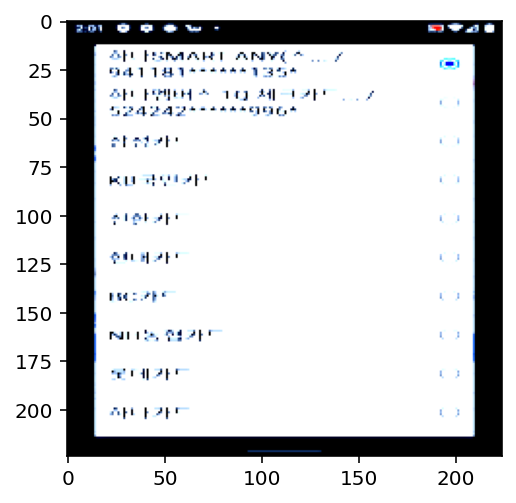

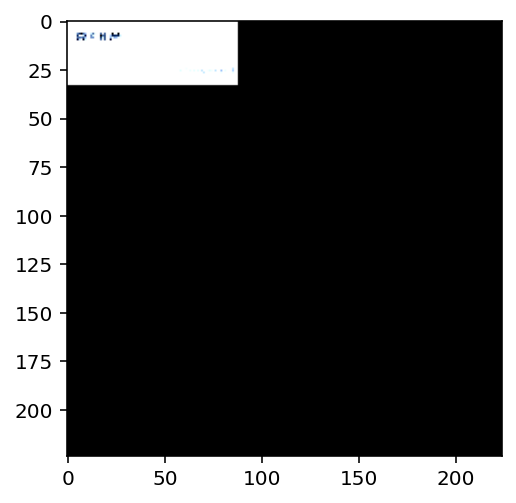

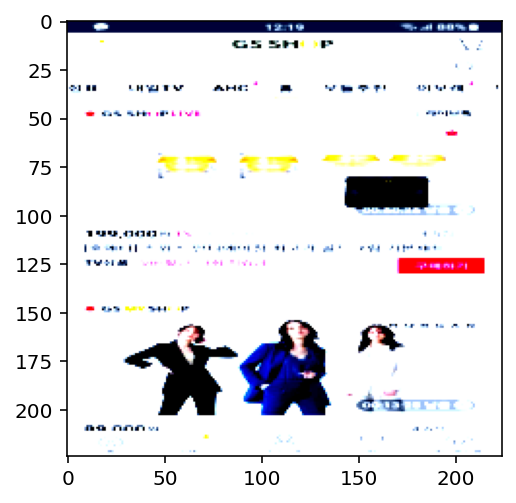

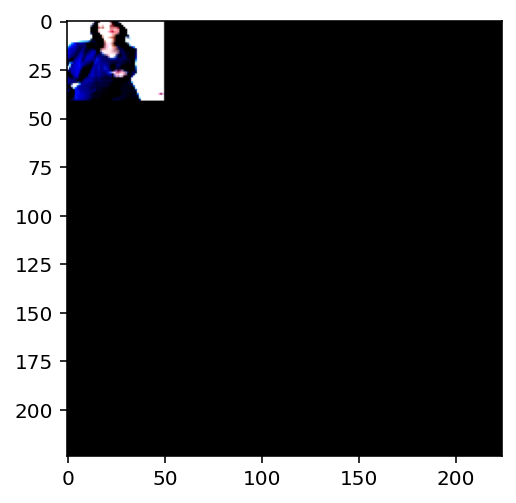

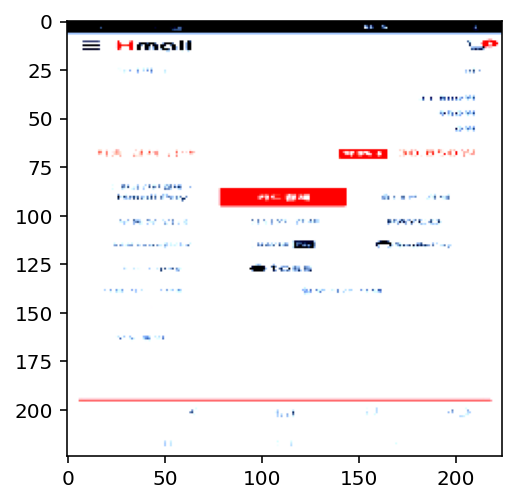

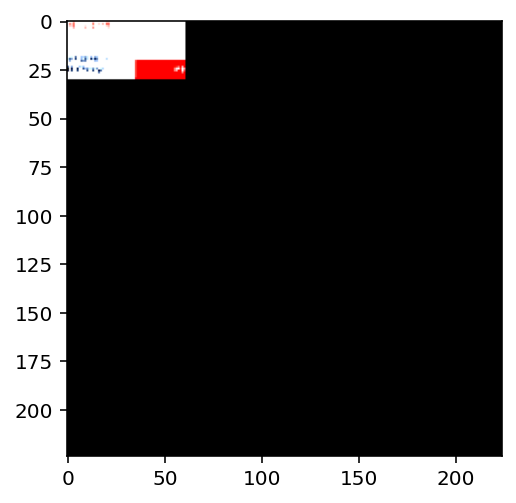

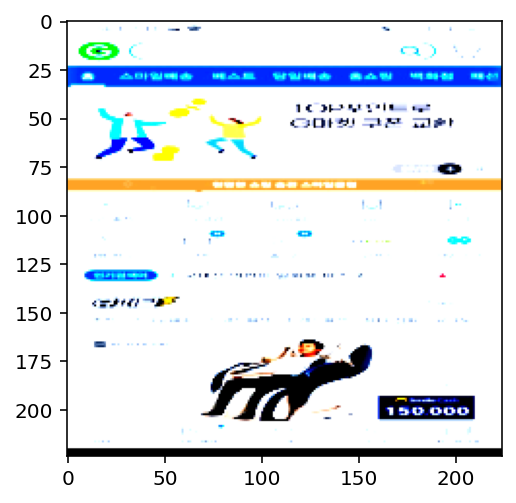

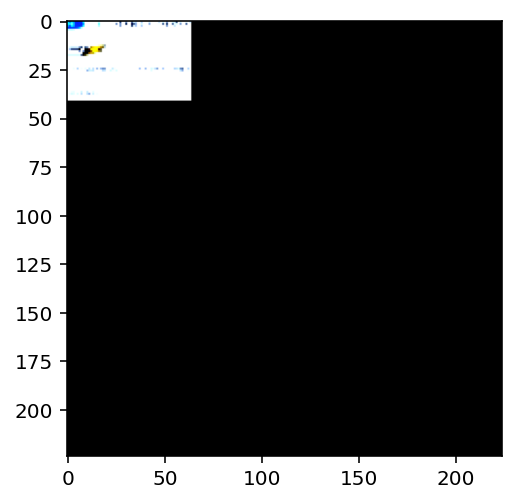

In [13]:
train_images, train_templates, train_labels = next(train_iter)

model.eval()
with torch.no_grad():
    train_images, train_templates = train_images.to(device), train_templates.to(device)

#    test_logps = model.forward(test_inputs)
#    test_ps = torch.exp(test_logps)

    for i in range(len(train_images)):
        plt.figure()
        img = train_images[i].cpu().numpy().transpose(1,2,0).clip(0.0, 1.0)
        plt.imshow(img)

        plt.figure()
        tmp = train_templates[i].cpu().numpy().transpose(1,2,0).clip(0.0, 1.0)
        plt.imshow(tmp)

#        img = torch.from_numpy(test_inputs[i].cpu().numpy().transpose(1,2,0))
#        img = np.clip(img, 0.0, 1.0)
#        view_classify(img, test_ps[i].cpu())
#model.train()

In [14]:
print(train_images.shape)
print(train_templates.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


In [15]:
feature1 = model.feature_extractor1.forward(train_images)
feature2 = model.feature_extractor2.forward(train_templates)
print(feature1.shape)
print(feature2.shape)

combined_feature = torch.cat((feature1, feature2), 1)
print(combined_feature.shape)

torch.Size([32, 1024])
torch.Size([32, 1024])
torch.Size([32, 2048])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
output = model.feature_identifier.forward(combined_feature)
print(output)


tensor([[-0.4987, -0.9347],
        [-0.4955, -0.9397],
        [-0.5000, -0.9328],
        [-0.5045, -0.9259],
        [-0.4899, -0.9486],
        [-0.5045, -0.9258],
        [-0.5058, -0.9239],
        [-0.4934, -0.9431],
        [-0.5020, -0.9297],
        [-0.5016, -0.9303],
        [-0.5022, -0.9294],
        [-0.4903, -0.9479],
        [-0.4957, -0.9395],
        [-0.5025, -0.9289],
        [-0.4994, -0.9337],
        [-0.4986, -0.9349],
        [-0.4944, -0.9415],
        [-0.4949, -0.9406],
        [-0.4906, -0.9473],
        [-0.5024, -0.9290],
        [-0.4911, -0.9467],
        [-0.5048, -0.9254],
        [-0.5088, -0.9193],
        [-0.5067, -0.9225],
        [-0.4977, -0.9363],
        [-0.5148, -0.9104],
        [-0.5084, -0.9199],
        [-0.5020, -0.9297],
        [-0.5030, -0.9281],
        [-0.5053, -0.9246],
        [-0.4986, -0.9350],
        [-0.5072, -0.9217]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [ ]:
output = model.forward(train_images, train_templates)
print(output)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-0.5976, -0.7988],
        [-0.5931, -0.8044],
        [-0.5943, -0.8028],
        [-0.5971, -0.7994],
        [-0.5971, -0.7994],
        [-0.5963, -0.8004],
        [-0.5939, -0.8034],
        [-0.6029, -0.7924],
        [-0.6013, -0.7942],
        [-0.5963, -0.8003],
        [-0.5946, -0.8025],
        [-0.5974, -0.7990],
        [-0.5930, -0.8045],
        [-0.5949, -0.8021],
        [-0.5931, -0.8043],
        [-0.5992, -0.7968],
        [-0.5968, -0.7997],
        [-0.5951, -0.8018],
        [-0.5885, -0.8100],
        [-0.5969, -0.7997],
        [-0.6012, -0.7944],
        [-0.5955, -0.8013],
        [-0.5972, -0.7993],
        [-0.5960, -0.8008],
        [-0.6015, -0.7941],
        [-0.5902, -0.8079],
        [-0.5977, -0.7987],
        [-0.5965, -0.8002],
        [-0.6008, -0.7949],
        [-0.5951, -0.8018],
        [-0.5957, -0.8011],
        [-0.5985, -0.7977]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [16]:
import random
import math

criterion = nn.NLLLoss()

params = list(model.feature_extractor1.classifier.parameters()) + list(model.feature_extractor2.classifier.parameters()) + list(model.feature_identifier.parameters())

optimizer = optim.Adam(params, lr=0.003)

epochs = 10
steps = 0
running_loss = 0
print_every = 10

min_sub_width = 10
min_sub_height = 10

for epoch in range(epochs):
    for images, templates, labels in train_loader:
        steps += 1      
        
        # Move input and label tensors to the default device
        images, labels, templates = images.to(device), labels.to(device), templates.to(device)
        
        logps = model.forward(images, templates)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            model.eval()
            with torch.no_grad():
                for test_images, test_templates, test_labels in test_loader:
                    test_images, test_labels, test_templates = test_images.to(device), test_labels.to(device), test_templates.to(device)

                    test_logps = model.forward(test_images, test_templates)
                    batch_loss = criterion(test_logps, test_labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    test_ps = torch.exp(test_logps)
                    top_p, top_class = test_ps.topk(1, dim=1)
                    equals = top_class == test_labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 0.710.. Test loss: 0.700.. Test accuracy: 0.488
Epoch 1/10.. Train loss: 0.702.. Test loss: 0.757.. Test accuracy: 0.488
Epoch 1/10.. Train loss: 0.723.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.692.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.692.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.694.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.695.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.692.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.693.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.693.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.692.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.693.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.694.. Test loss: 0.693.. Test accuracy: 0.512
Epoch 1/10.. Train loss: 0.693.. Test loss: 0.693..

KeyboardInterrupt: ignored

In [ ]:
print(num_test_samples)
print(j)
print(num_test_batches)

200
7
7


In [ ]:
model

TemplateIdentifier(
  (feature_extractor1): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, e